### Demo Notebook

#### How to get the non-photo images from a document
The purpose of this notebook is to demonstrate how to save embedded images     
that are not photos but line drawings and tables, to disk and give them      
a meaningful name to help with retrieval.   

These types of images are not identified as images when using pypdf but can be found using OpenCV.  
We will look at that approach.  

#### How to construct image file names
Once we have an image identified we also need to name it in a way that so it can be easily retieved by front end apps. An example would be an Azure Open AI RAG app that returns answers to questions based on a document as contecxt. You may want to display the image if the answewr refernce the figure in the answer.

As one possible solution, we will explore using Azure Document Intelligence to OCR'd text from a List of Figures and a list of Tables contained in the document itself. We will then parse the text to come up with names that can easily be mapped back to references in the document.

### Install needed libs

In [ ]:
#%pip install pillow 
#%pip install pypdf==3.9.0

### Check your pypdf verson
mustbe =>3.9.0
upgrade if necessary

In [99]:
import pypdf
print("Your version of pypdf is {}".format(pypdf.__version__))
# 
pypdf_version = int(pypdf.__version__.replace(".", ""))
if pypdf_version < 390:
    print("You need to upgrade your version of pypdf")
else:
    print("Your version of pypdf is fine")

Your version of pypdf is 3.9.0
Your version of pypdf is fine


### Using python to get images from a PDF  

The PDF document in this example (FMDS1202.pdf) contains many photo images.  
Lets use pypdf to create a function to retreive them.

In [97]:
#See https://pypdf.readthedocs.io/en/stable/user/extract-images.html?highlight=images#extract-images
from pypdf import PdfReader
import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
import matplotlib.image as mpimg
from pdf2image import convert_from_path
import pypdfium2 as pdfium
from azure.core.credentials import AzureKeyCredential
from azure.ai.formrecognizer import DocumentAnalysisClient

# ****************************************************
# A function to get all the images from a pdf document
# ****************************************************
def get_all_images_from_pdf_document(pdf_path):
    reader = PdfReader(pdf_path)
    total_images=0
    page_no=0
    for page in reader.pages:
        page_no += 1
        img_no=0
        for image_file_object in page.images:
            if len(image_file_object.data) < 5000:
                continue
            img_no += 1
            total_images+=1
            #
            # get the extension from image_file_object.name
            extension=image_file_object.name.split(".")[-1]
            # get the file name to use as a directory name 
            # from the pdf_path without the extension
            directory_name=pdf_path.split("/")[-1].split(".")[0]
            #
            # check if the dirctory exists, if not create it
            if not os.path.exists(directory_name):
                os.makedirs(directory_name)
            #
            with open("./" + directory_name + "/Doc_Pg_no_" + str(page_no) + "_img_no_" + str(img_no) + "." + extension, "wb") as fp:
                fp.write(image_file_object.data)
    return total_images
  
# *********************************************************************
# A function to get all the images from a single page in a pdf document
# *********************************************************************
def get_all_images_from_pdf_page(pdf_path, page_no):
    # set local vars
    reader = PdfReader(pdf_path)
    page = reader.pages[page_no]
    # init image counter
    img_no=0
    for image_file_object in page.images:
        # if the image sixe is less than 5kb just continue the loop
        if len(image_file_object.data) < 5000:
            continue
        #
        #increment the image counter
        img_no += 1
        #
        # get the extension from image_file_object.name
        extension=image_file_object.name.split(".")[-1]
        #
        # get the file name from the pdf_path without the extension
        directory_name=pdf_path.split("/")[-1].split(".")[0]
        #
        # check if the dirctory exists, if not create it
        if not os.path.exists(directory_name):
            os.makedirs(directory_name)
        #
        # write the image to disk
        with open("./" + directory_name + "/Page_no_" + str(page_no) + "_img_no_" + str(img_no) + "." + extension, "wb") as fp:
            fp.write(image_file_object.data)
        # loop back to the next image
    return img_no

# ***************************************
# a helper function for displaying images
# displays 2 images side by side with borders
# ***************************************
def show_two_images_with_borders(img1, img2, border_size=3):
    fig, axs = plt.subplots(1, 2)

    # Create a larger black image
    bordered_img1 = np.pad(img1, [(border_size, ), (border_size, ), (0, )], mode='constant', constant_values=0)
    bordered_img2 = np.pad(img2, [(border_size, ), (border_size, ), (0, )], mode='constant', constant_values=0)

    # Show first image with border
    axs[0].imshow(bordered_img1)
    axs[0].axis('off')  # Hide axes

    # Show second image with border
    axs[1].imshow(bordered_img2)
    axs[1].axis('off')  # Hide axes

    plt.subplots_adjust(wspace=0.05)  # Adjust space between subplots
    plt.show() 

# ***************************************
# a helper function for displaying images
# displays 2 images side by side
# ***************************************    
def show_two_images(img_path1, img_path2):
    img1 = mpimg.imread(img_path1)
    img2 = mpimg.imread(img_path2)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.axis('off')

    plt.show()    
    
# **************************************
# a helper function to display an image
# **************************************
def show_image(image_file_name):
    image = plt.imread(image_file_name)
    # show the image with axis turned off
    plt.axis('off')  # Hide axis
    #size the image  at 3 inches wide
    rcParams['figure.figsize'] = 3, 3
    # show the image
    plt.imshow(image)
    plt.show()  

# ********************************************
# a helper function to display image of a page
# shows entire page as an image
# ********************************************    
from pdf2image import convert_from_path, exceptions

def show_page(pdf_file_path, page_number):
    # get the pdf
    pdf = pdfium.PdfDocument(pdf_file_path)
    #
    # get the page
    page = pdf[page_number]
    #
    # render image
    pil_image = page.render(scale=4).to_pil()
    #
    # show the image with axis turned off
    plt.axis('off')  # Hide axis
    #size the image  at 3 inches wide
    rcParams['figure.figsize'] = (11, 8.5)
    # show the image
    plt.imshow(pil_image)
    plt.show()
    
def show_two_pages(pdf_file_path, page_number1, page_number2):
    # get the pdf
    pdf = pdfium.PdfDocument(pdf_file_path)
    #
    # get the first page
    page1 = pdf[page_number1]
    # render image
    pil_image1 = page1.render(scale=4).to_pil()
    #
    # get the second page
    page2 = pdf[page_number2]
    # render image
    pil_image2 = page2.render(scale=4).to_pil()
    #
    # show the image with axis turned off
    plt.axis('off')  # Hide axis
    #
    #show the two pages side by side with each page sized at 11, 8.5
    rcParams['figure.figsize'] = (11, 8.5)
    #
    # show the first page
    plt.subplot(1, 2, 1)
    plt.imshow(pil_image1)
    #
    # show the second page
    plt.subplot(1, 2, 2)
    plt.imshow(pil_image2)
    #
    # show the image
    plt.show()

print("the functions have been created")

the functions have been created


### Execute the function to reteive photos from the document.

This document (FMDS1202.pdf) contains 30 photo images.

Our pypdf functions works fine to retrieve these.  
Example 1: We execute it first to retrive all photos in the document from all pages.    
Example 2: Then we execute it again to get photos just from a single page.  

Example 1 - Total images in the document: FMDS1202.pdf is 30 
Example 2 - Total images in the document:FMDS1202.pdf page number: 11 is 1 

below is the image found on page 11



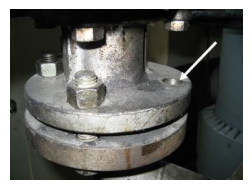

In [96]:
# **********
# Example 1
# **********
# get all images from all pages of the pdf document
pdf_path="FMDS1202.pdf"
total_images=get_all_images_from_pdf_document(pdf_path)
print("Example 1 - Total images in the document: {} is {} ".format(pdf_path, total_images))
#
# **********
# Example 2
# **********
# get all images from page 11 of the pdf document
pdf_path="FMDS1202.pdf"
page_no=11
total_images=get_all_images_from_pdf_page(pdf_path, page_no)
print("Example 2 - Total images in the document:{} page number: {} is {} ".format(pdf_path, page_no, total_images))
#
# ***********************
# lets display this photo
# ***********************
print("\nbelow is the image found on page 11\n")
show_image('.\FMDS1202\Page_no_11_img_no_1.jpg')



Now lets do the same using a different document
### Example: from a document that has only a few photos ...
####                                       ... but does have many "Figures" and "Tables".
These "Figures" are line drawings and tables images embedded in the PDF. They are just not photos.

The file used in this example (FMDS0200.pdf) contains 10 photos and many line drawings and tables (referred to as Figures)

When we run the same code as in the prior example, the "Figures" and "Tables" are not captured as were the photos in the last example.  
Neither of the two figure types, tables and drawings,  are in the pages.images list.

Example 3 - Total images in the document: FMDS0200.pdf is 10 

**************   Notice that no images are found on this page   *************************
Example 4 - Total images in the document:FMDS0200.pdf page number: 28 is 0 


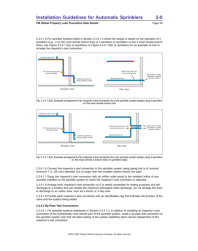

In [3]:
# Example 3
# get all images from all pages of the pdf document
pdf_path="FMDS0200.pdf"
total_images=get_all_images_from_pdf_document(pdf_path)
print("Example 3 - Total images in the document: {} is {} ".format(pdf_path, total_images))
#
# Example 4
# get all images from page 28 of the pdf document
pdf_path="FMDS0200.pdf"
page_no=28
total_images=get_all_images_from_pdf_page(pdf_path, page_no)
print("\n**************   Notice that no images are found on page 28   *************************")
print("Example 4 - Total images in the document:{} page number: {} is {} ".format(pdf_path, page_no, total_images))
#
# **************************************************
# no images were found on page 11 of this document
# lets display this page to see what was on the page
# **************************************************
show_page(pdf_path, page_no)

 ... but as you can see above there were two images on the page.  
### So how can we get these "Figures"
Lets create a funtion that uses Open CV.

In [95]:
import cv2

# *********************************************************************
# A function to get all the tables and line drawings 
# from a all pages in a pdf document
# *********************************************************************
def get_rectangles(image):
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    rectangles_out=[]
    ## this will get all the shapes on the pages
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # skip lines we're looking for rectangles
    # cnts will hold all the shapes
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    #
    # Now lets loop through the shapes and find the rectangles
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.015 * peri, True)
        # this will filter everything except the rectangles
        if len(approx) == 4:
            x,y,w,h = cv2.boundingRect(approx)
            # We only want the larger ones
            if h > 200:
                rectangles_out.append([x,y,w,h])
    return rectangles_out
#
print("function 'get_rectangles' created")

function 'get_rectangles' created


### Now lets use the function (created above) on that same page of the PDF
It writes all the images found in the document out to disk.

The function found a total of 136 images (tables and line drawings) in the document
below are the two images found on page 28


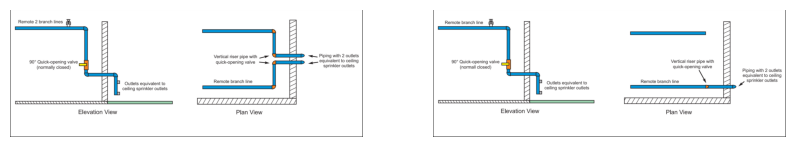

In [94]:
import pypdfium2 as pdfium
import numpy as np
import os
#
# set the path to the pdf document
pdf_path="FMDS0200.pdf"
pdf = pdfium.PdfDocument(pdf_path)
#
# get the file name from the pdf_path without the extension
directory_name=pdf_path.split("/")[-1].split(".")[0]
#
# check if the dirctory exists, if not create it
if not os.path.exists(directory_name):
    os.makedirs(directory_name)
#
# initialize the counter for the images
img_no=0
#
# loop through the pages of the pdf document
total_images=0
all_images=[]
for page_no in range(len(pdf)):
    img_no=0
    page = pdf[page_no]
    image = page.render(scale=4).to_pil()
    numpy_image = np.array(image)
    rects=get_rectangles(numpy_image)
    total_images=total_images+len(rects)
    for rect in rects:                      
        img_no += 1
        x,y,w,h=rect
        file_name="./" + directory_name + "/Page_no_" + str(page_no+1) + "_img_no_" + str(img_no) + "." + 'png'
        image_desc=[file_name, str(img_no) , str(page_no+1)]
        all_images.append(image_desc)
        image.crop((x,y,x+w,y+h)).save(file_name)
#
print("The function found a total of {} images (tables and line drawings) in the document".format(total_images))
#
# it found 2 on page 28, lets see those images 
print("below are the two images found on page 28")
img1='.\FMDS0200\Page_no_29_img_no_1.png'
img2='.\FMDS0200\Page_no_29_img_no_2.png'
show_two_images(img1, img2)  

### Now we need a way to get the Figure or Table id that are used

In the sample document that is being used, all Figures and Tables are numbers in a caption below the image or table. The numbers look like this:  ***Table 2.4.3.1.3***   or this:   ***Fig. 2.4.3.1.3***  
(In the code these are catured into a variable called fig_str, short for "figure string")

Ideally we want to save the file to disk using that number so we can easily retrieve it  
whenever it is being referenced from some text in the document taht we are displaying  
to the user and we want to pop up the figure or table for reference.

In our demo's sample document there is a section that list all the figures and another  
section that list all tables. 

Your source documents may not have lists like in the demo's sample document and this approach may not be a good fit for you use case. Another approach might be to collect the image captions as you OCR the document for the RAG ingestion and keep them in a separate data store that you maintain just name extracted images.

Back to sample docs we have... Lets look at those pages with the List of Figures and Tables...

C:\Users\wawilk\AppData\Local\Temp\ipykernel_15420\3520807057.py:176: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


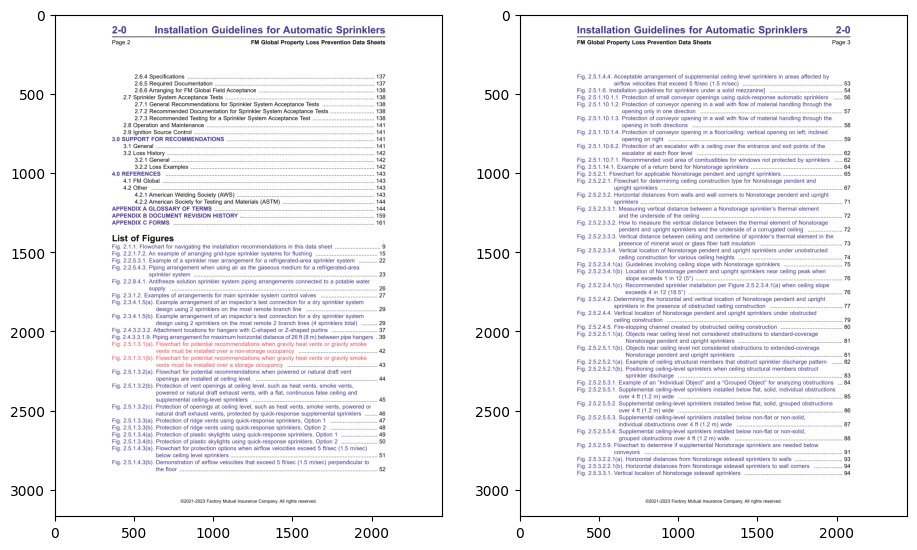

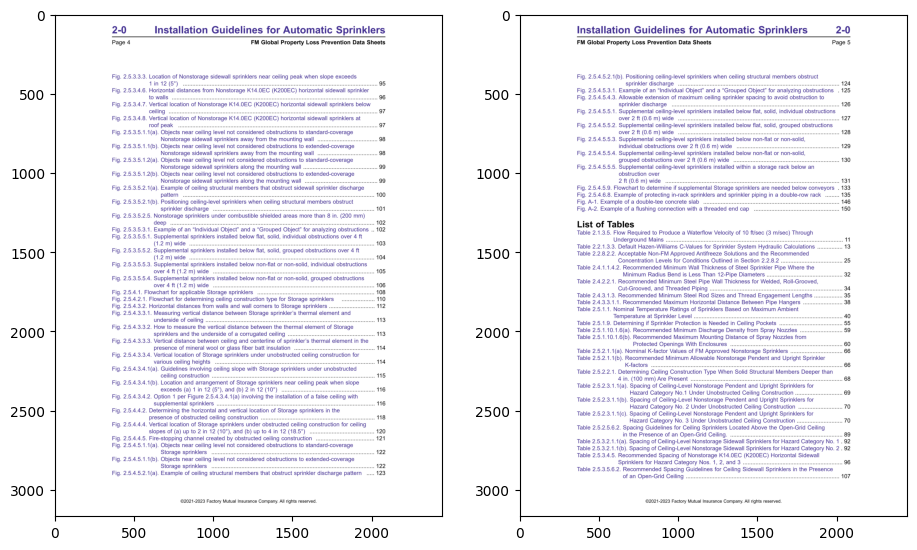

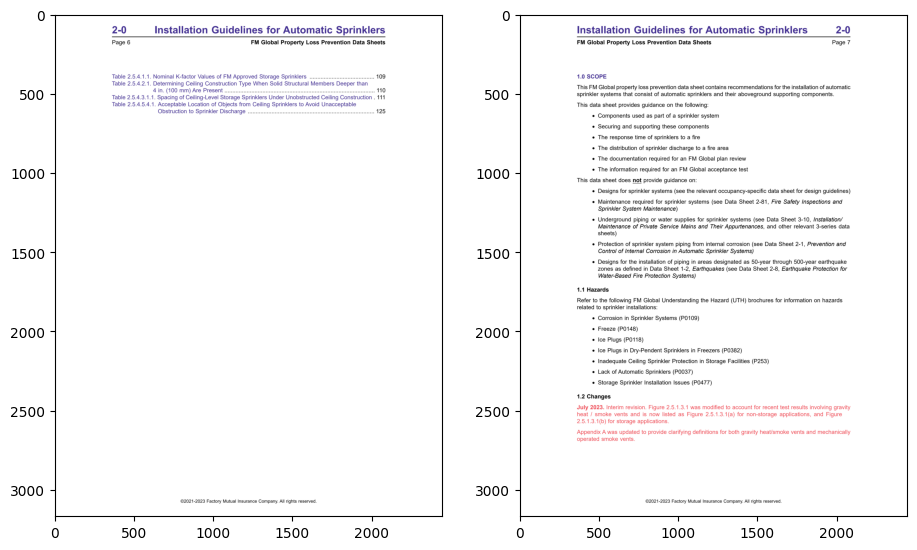

In [6]:
# Show the List of Figures page (Page #2 in the document- page index=1)
# and the List of Tables starts on page 5 (page index=4) and
# the List of Tables ends on page 6 (page index=5)
# then the actual document starts on page 7 (page index=6)
pdf_path="FMDS0200.pdf"
show_two_pages(pdf_path, 1, 2)
show_two_pages(pdf_path, 3, 4)
show_two_pages(pdf_path, 5, 6)

### Get our envionment vars from the .env file

We are going to need some additional variables.

In [ ]:
from dotenv import load_dotenv
# get env variables from .env file
load_dotenv()
form_recognizer_key = os.getenv("AZURE_FORM_RECOGNIZER_KEY")
form_recognizer_endpoint = os.getenv("AZURE_FORM_RECOGNIZER_ENDPOINT")
# *****************************************
# Configure Document Intelligence API
# *****************************************
sas_key = os.getenv("AZURE_BLOB_ACCOUNT_SAS_KEY")
form_recognizer_key = os.getenv("AZURE_FORM_RECOGNIZER_KEY")
form_recognizer_endpoint = os.getenv("AZURE_FORM_RECOGNIZER_ENDPOINT")
storage_account_url = os.getenv("AZURE_BLOB_ACCOUNT_URL")
container_name=os.getenv("AZURE_BLOB_CONTAINER_NAME")
test_document_name=os.getenv("TEST_DOCUMENT_NAME")
#
#******************
skip=1
#******************
# set skip to 0 to 
# print the values
#******************
if skip==0:
    print(form_recognizer_key)
    print(form_recognizer_endpoint)
    print(form_recognizer_key)
    print(form_recognizer_endpoint)
    print(storage_account_url)
    print(container_name)
    print(test_document_name)
#
print("environment variables have been loaded from the .env file into local vars")

environment variables have been loaded from the .env file into local vars


#### Now on to using Azure Document Intelligence to OCR

We can use Azure Document Intelligence to get the text from these pages (1-5).
Once we have the text we can parse it, format it and match it up to the images we extract. 
This should allow us to name the images to make them easy to locate when referenced in the document.

First, lets create a function to OCR the text using he Azure Document Intelligence API.

In [93]:
# *********************************************************
# A function to call the Document Intelligence API in Azure
# Passing in the URL of the document to be analyzed
# *********************************************************
def get_content(document_url, pages_to_ocr):
    import os
    from azure.ai.formrecognizer import DocumentAnalysisClient
    from azure.core.credentials import AzureKeyCredential
    #
    #azure_form_recognizer_client = AzureFormRecognizerClient()
    document_analysis_client = DocumentAnalysisClient(endpoint=form_recognizer_endpoint, credential=AzureKeyCredential(form_recognizer_key))
    poller = document_analysis_client.begin_analyze_document_from_url("prebuilt-layout", document_url, pages=pages_to_ocr)  
    #
    # other possible values for the model are "prebuilt-document" and "prebuilt-read" and "prebuilt-layout"
    #poller = document_analysis_client.begin_analyze_document_from_url("prebuilt-document", document_url)  
    #poller = document_analysis_client.begin_analyze_document_from_url("prebuilt-read", document_url)  
    #poller = document_analysis_client.begin_analyze_document_from_url("prebuilt-layout", document_url)  
    return poller.result()
#
print("function 'get_content' created")

function 'get_content' created


### Now make the call to our function to get the Docucument Intelligence result

Note that I have access to the blob store by using a SAS key.  
The URL, SAS key, storage account, container name and page name are all environment variables.

In [91]:
# How you construct the URL is dependent on how you formatted the env vars
test_pdf_full_url = storage_account_url + "/" + container_name + "/" + test_document_name + sas_key
# print("Getting document at URL: {}".format(test_pdf_full_url))
#
# I need pages printed 2 through 6. 
# ("pages_to_ocr" is indexed starting at 1 not zero.)
pages_to_ocr="2-6"
#
result = get_content(test_pdf_full_url, pages_to_ocr)
print("OCR results have been returned from the Document Intelligence API and stored in the 'result' variable")

OCR results have been returned from the Document Intelligence API and store in the 'result' variable


### Parse and explore the result
Lets print out the lines in the two lists (***List of Figures*** and ***List of Tables***) so we can develop an approach.

Note: For this demo we are excluding the forms in the appendix which could also be captured

In [73]:
import re
cnt=0
mytext=result.content
cnt=0
all_text=[]
# split mytext on new line
all_text=mytext.split('\n')
#*****************************************************
# Identify stuff we can get rid of
#*****************************************************
# get the document number 
header_1=all_text[0]
#
# get the page number, the first 5 characters of header_2
header_2=str(all_text[1])[0:5]
#
# get the document title
header_3=all_text[2]
#
# get the document set name
header_4=all_text[3]
#
# get the footer (starts with a "@")
for cur_line in all_text:
    if cur_line.startswith("@"):
        footer=cur_line
        break
#
#******************
skip=1
#******************
# set skip to 0 to 
# print the values
#******************
if skip==0:
    print("header_1=",header_1)
    print("header_2=",header_2)
    print("header_3=",header_3)
    print("header_4=",header_4)
    print("footer=",footer)
#*****************************************************
# lets remove all header and footer lines from all_text
#*****************************************************
clean_text=[]
for l in all_text:
 if not l.startswith(header_1):
     if not l.startswith(header_2):
         if not l.startswith(header_3):
             if not l.startswith(header_4):
                 if not l.startswith(footer):
                     clean_text.append(l)
# set all_text=clean_text                    
all_text=clean_text
#*****************************************************
# begin processing the text from the two lists
#*****************************************************
for cur_line in all_text:
    cnt=cnt+1
    # we need to find our starting point
    if cur_line.startswith("List of Figures"):
        # start of Figures list found
        print("*******************************")
        print("Figure list starts at line: {}".format(cnt))
        print("*******************************")
        cnt=cnt+1
        prt_ctr=0
        # here looping through figures list
        while cnt < (len(all_text)):
            cur_line = all_text[cnt]
            if cur_line.startswith("List of Tables"):
                # start of Tables list found
                print("*******************************")
                print("Table list starts at line: {}".format(cnt))
                print("*******************************")
                prt_ctr=0
                cnt=cnt+1
                break
            #**************************************************
            # This will show you the "List of Figures" section
            # we want to print it so we can understand the data
            #**************************************************
            print("line number: {}    {}".format(str(cnt),cur_line))
            cnt=cnt+1
            prt_ctr=prt_ctr+1
        #
        # here we looping through tables list
        while cnt < (len(all_text)):
            cur_line = all_text[cnt]
            if cur_line.startswith("1.0 SCOPE"):
                # start of document found
                print("*******************************")
                print("Actual document text starts at line: {}".format(cnt))
                print("*******************************")
                break
            #**************************************************
            # This will show you the "List of Tables" section
            # we want to print it so we can understand the data
            #**************************************************
            print("line number: {}    {}".format(str(cnt),cur_line))
            cnt=cnt+1
            prt_ctr=prt_ctr+1

*******************************
Figure list starts at line: 45
*******************************
line number: 46    9
line number: 47    Fig. 2.2.1.7.2. An example of arranging grid-type sprinkler systems for flushing
line number: 48    15
line number: 49    Fig. 2.2.5.3.1. Example of a sprinkler riser arrangement for a refrigerated-area sprinkler system
line number: 50    22
line number: 51    Fig. 2.2.5.4.3. Piping arrangement when using air as the gaseous medium for a refrigerated-area sprinkler system
line number: 52    23
line number: 53    Fig. 2.2.8.4.1. Antifreeze solution sprinkler system piping arrangements connected to a potable water supply
line number: 54    26
line number: 55    Fig. 2.3.1.2. Examples of arrangements for main sprinkler system control valves
line number: 56    27
line number: 57    Fig. 2.3.4.1.5(a). Example arrangement of an inspector's test connection for a dry sprinkler system design using 2 sprinklers on the most remote branch line
line number: 58    29


### Things to notice from the output of the previous cell
A figure or table number looks like this: 2.4.3.2.3.2

***Page numbers are not always in the same place. I see 3 possible places.***
(Of course your source documents may need a comletely different set of parsing rules)  

**Case 1**  
*Sometimes the page number is on same line as the figure or table number.*  
(For a same line example, see  Fig. 2.5.3.5.3.1 in the above cell's output)

**Case 2**  
*Sometimes the page number is on the next line all by itself.*      
(For a 1 lines ahead example, see Table 2.4.2.2.1 in the above cell's output)

**Case 3**  
*Sometimes the page number it is on the next next line all by itself.*       
(For a 2 lines ahead example, see Fig. 2.5.4.5.5.5 in the above cell's output)

We need to get all the figure numbers, table numbers and their associated page numbers  
together in a single list sorted by page number

### Get a definitive combined list of the Figures and Tables 
taken from the ***List of Figures*** and the ***List of Tables***

Then we will summarize the combined list by page number to get image counts on each page.

In [74]:
# we will reuse the all_text array from above code cell
# because it is already clean
type_1=[]
type_2=[]
type_3=[]
cnt=0
check_string="Fig. "
check_type="F"
for cur_line in all_text:
    cnt=cnt+1
    if cur_line.startswith("List of Figures"):
        #print("Figures found")
        cnt=cnt+1
        while cnt < (len(all_text)):
            #******************************
            # determine cur_line
            #******************************
            cur_line = all_text[cnt]
            if cur_line.startswith("List of Tables"):
                check_string="Table "
                check_type="T"
                cnt=cnt+1
                cur_line = all_text[cnt]
            #******************************
            # determine next_line
            #******************************
            if cnt < (len(all_text)-1):
                next_line = all_text[cnt+1]
                if next_line.startswith("List of Tables"):
                    next_line = 'End'
            else:
                next_line = 'End'
            #******************************
            # determine next_next_line
            #******************************
            if cnt < (len(all_text)-2):
                next_next_line = all_text[cnt+2]
                if next_next_line.startswith("List of Tables") or next_line.startswith("List of Tables") or next_line=="End":
                    next_next_line = "End"
            else:
                next_next_line = 'End'
            #***************************************************************************************
            # get the type 1s: The ones where we check if current line starts with "Fig. " and 
            # next line also starts with "Fig. " (or if almost at the end of the list, the next line = "End").
            # If true, this means the page number for cur_line is  at the end of the cur_line. 
            #***************************************************************************************
            if ((cur_line.startswith(check_string) and next_line.startswith(check_string)) | 
                    ((cur_line.startswith(check_string) and (next_line=="End")))):
                # find the number at the very end of the cur_line, it will be the page number for the current line
                # example 
                #   the cur_line might look like this: "Fig. 2.4.3.3.1.8. This is blah blah blah" ....25              
                # and 
                # (
                #   the next_line might look like this: "Fig. 2.4.3.3.1.9. This is blah blah blah" ....32
                # or
                #   the next_line might look like this: "Fig. 2.4.3.3.1.9. This is blah blah blah"
                # )
                # if so
                #   on the cur_line, get the substring after "Fig. " and before the "This is blah blah blah", but remove the ending period
                #   so in this example: fig_str="2.4.3.3.1.8"
                fig_str=".".join(cur_line.split(" ")[1].split(".")[0:-1])
                #
                # Get the number 25 from the end of the cur_line, it is the page_no for cur_line
                # sometimes there dots in front of the page numbert, sometimes there are no dots before the page number
                # example: Table 2.5.4.5.4.1. Acceptable Location of Objects from Ceiling Sprinklers to Avoid Unacceptable Obstruction to Sprinkler Discharge 125
                page_no=cur_line.split(" ")[-1]
                # check page number and if not a number, then set it to 0
                if page_no.isdigit()==False:
                    page_no=0
                #
                type_1.append([check_type, fig_str, page_no])
                #
                # make the next_line the cur_line by incrementing the counter and looping
                cnt=cnt+1
                continue
            #***************************************************************************************
            # Get the type 2s: The ones where if you check if cur_line and it starts with "Fig. " and 
            # next_line doesn't start with "Fig. " and the next_next_line starts with "Fig. " 
            # (or if almost at the end of the list, the next_next line = "End").
            # If true, this means that next_line contains the page_no for cur_line.
            #***************************************************************************************
            if (((cur_line.startswith(check_string)) and (next_line.startswith(check_string)==False) and (next_next_line.startswith(check_string))) | 
                ( (cur_line.startswith(check_string)) and (next_line.startswith(check_string)==False) and (next_next_line=="End")) ):
                # example: the cur_line might look like this: "Fig. 2.4.3.3.1.9. This is blah blah blah"
                # and             
                # example: the next_line might look like "25"
                #
                # get the substring after "Fig. " and before the "This is blah blah blah", but remove the ending period
                # so in this example: fig_str="2.4.3.3.1.9"
                fig_str=".".join(cur_line.split(" ")[1].split(".")[0:-1])
                #
                # Get the number 25 from the next_line, it is the page_no for cur_line
                page_no=next_line.strip().lstrip('.')
                # check page number and if not a number, then set it to 0
                if page_no.isdigit()==False:
                    page_no=0
                #
                # append the type 2 to the type_2 array
                type_2.append([check_type, fig_str, page_no])
                #
                # both cur_line and next_line have been processed, so increment the counter by 2
                cnt=cnt+2
                continue
            #***************************************************************************************
            # Get the type 3s: The ones where check if you check the current line and it starts with "Fig. " and 
            # the next_line doesn't start with "Fig. " and the next_next_line also does not starts with "Fig. "
            # In this case the page number for cur_line is equal to the next_next_line.
            #***************************************************************************************
            if cur_line.startswith(check_string) and (next_line.startswith(check_string)==False) and (next_next_line.startswith(check_string)==False):
                # find the number in next_next_line, it will be the page number for the current line
                # next_next_line might look like this "25"
                page_no=next_next_line.strip().lstrip('.')
                # append the type 3 to the type_3 array
                type_3.append([check_type, fig_str, page_no])
                 # the cur_line, next_line and next_next_line have been processed, so increment the counter by 3
                cnt=cnt+3
                # and loop
                continue
            cnt=cnt+1
#
#******************
skip=1
#******************
# set skip to 0 to 
# print the values
#******************
if skip==0:
    # type_1 will contain elements like these two examples:
    # example 1: ['F', '2.4.3.3.1.9', '39'] has a check_type="F" 
    # example 2: ['T', '2.5.4.1.1', '110'] has a check_type="T"
    # print the count of elements in type_1 that have a check_type="F"
    # and print the count of elements in type_1  that have a check_type="T"
    print("all type_1s with 'F' check_type = ", len([e for e in type_1 if e[0] == "F"]))
    print("all type_1s with 'T' check_type = ", len([e for e in type_1 if e[0] == "T"]))
    # grand total of all type_1s
    print("all type_1s, the total count = ", len(type_1))
    print("******************************************")
    for e in type_1:
        print(e)
    print("\nall type_2s with 'F' check_type = ", len([e for e in type_2 if e[0] == "F"]))
    print("all type_2s with 'T' check_type = ", len([e for e in type_2 if e[0] == "T"]))
    print("all type_2s, the total count =", len(type_2))
    print("******************************************")
    for e in type_2:
        print(e)
    print("\nall type_3s with 'F' check_type = ", len([e for e in type_3 if e[0] == "F"]))
    print("all type_3s with 'T' check_type = ", len([e for e in type_3 if e[0] == "T"]))
    print("all type_3s, the count = ", len(type_3))
    for e in type_3:
        print(e)
    print("******************************************")
#
#merge type_1 and type_2 into one array
type_1_and_2_and_3=[]
#
# combine the lists
type_1_and_2_and_3=type_1 + type_2 + type_3
#
# sort the type_1_and_2 array by page number, starting with the lowest page number
type_1_and_2_and_3=sorted(type_1_and_2_and_3, key=lambda x: int(x[2]))
#
#******************
skip=1
#******************
# set skip to 0 to 
# print the values
#******************
if skip==0:
    # print the sorted array, but if an element has a page_no=0, 
    # element example: ['F', '2.5.4.5.5.5', 0]
    # print the work "error" next to it like this ['F', '2.5.4.5.5.5', 0] error
    print("******************************************")
    for e in type_1_and_2_and_3:
        if e[2] == 0:
            print(e, "error")
        else:
            print(e)
    print("\n******************************************")
    print("The total count in the combined list = ", len(type_1_and_2_and_3))
    print("******************************************")
# we now have a combined array of type_1 and type_2 and type_3


### Summarize the combined list
We can summarize the newly created combined list  
and/or display out the detail to help find anything that might be missing.

In [78]:
# summarize the "type_1_and_2_and_3" array by page number
# each element in all_images looks like this:['T', '2.1.3.5', '11'] or ['T', '2.2.1.3.3', '13']
# where the 11 or the 13 is the page number
# we will create a new array called "figs_and_tables_by_page_no"
# where each element in images_by_page_no will be an array of page number and count of images
# and the index of the element will be the page number
# so figs_and_tables_by_page_no[1] will be a count of image files for page 1
# and figs_and_tables_by_page_no[2] will be the count of images for page 2
# and so on
#
# create an array to summarize in
figs_and_tables_by_page_no=[]
#
# loop through the type_1_and_2_and_3 array
# created priously in an earlier code cell
for e in type_1_and_2_and_3:
    # get the page number
    page_no=int(e[2])
    # if the page_no is greater than the length of figs_and_tables_by_page_no
    # then we need to add elements to figs_and_tables_by_page_no until we get to the page_no
    while page_no > len(figs_and_tables_by_page_no):
        figs_and_tables_by_page_no.append(0)
    # increment the count of images for this page
    figs_and_tables_by_page_no[page_no-1]=figs_and_tables_by_page_no[page_no-1]+1
#
#******************
skip=1
#******************
# set skip to 0 to 
# print the values
#******************
if skip==0:
    # print the figs_and_tables_by_page_no array
    print("****************************************************")
    for i in range(len(figs_and_tables_by_page_no)):
        print("page_no: {}   count of images: {}".format(i+1, figs_and_tables_by_page_no[i]))
    print("****************************************************")
#
# print the total count of images
print("****************************************************")
print("The total count of images across all pages is {}".format(sum(figs_and_tables_by_page_no)))    
print("****************************************************")

****************************************************
The total count of images across all pages is 124
****************************************************


### To check things out even further ...  

We will summarize of list of images written to disk in the same way (by page number)

In [81]:
# To check that we have evertthing we can summarize the all_images array by page number.
#
# Each element in all_images looks like this: [file_name, str(img_no) , str(page_no+1)]
#   where the first element is the image file name and the second element is the page number
# We will create a new array called images_by_page_no where each element in images_by_page_no 
#   will be an array of page number and count of images and the index of the element will be the page number.
# And so images_by_page_no[1] will be a count of image files for page 1, and images_by_page_no[2] 
#   will be the count of images for page 2 and so on
# We need to exclude images in "all_images" array that are on pages with page numbers greater than the 
#   highest page in figs_and_tables_by_page_no array. Those are most likely full page forms and not images of
#   figures or tables. they are listed in the Appendix of the document
images_by_page_no=[]
for e in all_images:
    page_no=int(e[2])
    if page_no > len(figs_and_tables_by_page_no):
        continue
    while page_no > len(images_by_page_no):
        images_by_page_no.append(0)
    images_by_page_no[page_no-1]=images_by_page_no[page_no-1]+1
#
#*********
skip = 1
#*********
# set to 0 
# to print  by page
#*********
if skip == 0:
    print("the images_by_page_no array")
    print("**************************************************")
    print("Total images by page number")
    for i in range(len(images_by_page_no)):
        print("page_no: {}   count of images: {}".format(i+1, images_by_page_no[i]))
print("**************************************************")
# print the total count of images
print("The total count of images written to disk is {}".format(sum(images_by_page_no)))
print("**************************************************")


**************************************************
The total count of images written to disk is 126
**************************************************


### Lets compare the two list to find any descrepancies

If any full page images were written to disk, these are typically Forms and are listed
in an Appendix. 

For this project they are not considered Figures or Tables.  
That exclusion is still to be done.

In [89]:
# comare the two arrays and print out a list of which pages 
# are missing some images
#
# For the items where the count by page number is not matched across the 2 arrays
# We will print the page number and the count of images for that page number side by side from both arrays
print("\n***********  There should be no items below  *****************")
for i in range(len(figs_and_tables_by_page_no)):
    if figs_and_tables_by_page_no[i] != images_by_page_no[i]:
        print("page_no: {}\tcount of disk images: {}\tcount of figs and tables: {}".format(i+1, images_by_page_no[i], figs_and_tables_by_page_no[i]))  
print("**************************************************************")
# print the total count of images
print("The total count of images compared is {}".format(sum(images_by_page_no)))
print("**************************************************************")



***********  There should be no items below  *****************
page_no: 9	count of disk images: 1	count of figs and tables: 0
page_no: 109	count of disk images: 1	count of figs and tables: 0
**************************************************************
The total count of images compared is 126
**************************************************************


### Rename the files to match the fig or table string

This is so we can find a reference Figure or table when referenced from a document  
and pop it up for the user to see as a reference.  There should be enough info in  
the document to build the correct file name.

An example: On page 22 there is this line in the document:  
"See Figure 2.2.5.3.1 for an example of the riser piping arrangement of a refrigerated-area sprinkler"
system.

In [68]:
# we want to rename the files to match the fig or tabel string

# Steps:
# 1. for each page in the type_1_and_2_and_3 array get each image one by one
#     get the "F" or "T"
#     get the fig_str value from the type_1_and_2_and_3
#     construxt file name using the "F" or "T" + "_" + fig_str
# 2. get the same ordinal positioned image on the same page numbered page from the all_images array
#     get the filename value from the all_images array
# 3. rename the file to have the name of  ("F" or "T") + "_" + fig_str
# 4. move on to the next image on the page
# 5. when all images on the page are renamed, move onto the next page
# get a list of distinct page from type_1_and_2_and_3
distinct_pages=[]
for e in type_1_and_2_and_3:
    page_no=int(e[2])
    if page_no not in distinct_pages:
        distinct_pages.append(page_no)
#
# sort the distinct_pages array
distinct_pages=sorted(distinct_pages)
for page in distinct_pages:
    # get all the images from type_1_and_2_and_3 that are on that page
    images_from_page_from_type_1_and_2_and_3 =[]
    for e in type_1_and_2_and_3:
        if int(e[2])==page:
            images_from_page_from_type_1_and_2_and_3.append(e)
    #
    # get all the images from all_images array that are on that page
    images_from_the_all_images_array =[]
    for e in all_images:
        if int(e[2])==page:
            images_from_the_all_images_array.append(e)
    # sort the images_from_the_all_images_array by img_no
    images_from_the_all_images_array=sorted(images_from_the_all_images_array, key=lambda x: int(x[1]))
    #
    # because the fig_str may be duplicated across the "F"s and the "T"s
    # we must prefix them. Rename the files  ("F" or "T") + "_" + fig_str
    for i in range(len(images_from_page_from_type_1_and_2_and_3)):
        fig_str=images_from_page_from_type_1_and_2_and_3[i][1]
        fig_prefix=images_from_page_from_type_1_and_2_and_3[i][0]
        new_name=fig_prefix + "_" + fig_str
        file_name=images_from_the_all_images_array[i][0]
        #
        # get the extension
        extension=file_name.split(".")[-1]
        ##
        # get the directory name
        directory_name=file_name.split("/")[1]
        #
        # before trying to rename check if file with name=file_name exists
        if (os.path.isfile(file_name)==False):
            # if it does, not skip the rename
            continue
        #
        # rename the file
        # before trying to rename check if new name already exists
        if os.path.isfile("./" + directory_name + "/" + new_name+ "." + extension):
            # if it does, then delete it
            os.remove("./" + directory_name + "/" + new_name+ "." + extension)
        # and then do the rename
        os.rename(file_name, "./" + directory_name + "/" + new_name+ "." + extension)
        #
        # print("renamed file: {} to {}".format(file_name, "./" + directory_name + "/" + new_name + "." + extension))
    #print("done with page: {}".format(page))
print("done renaming files")

    

done renaming files


### Now the renamed files can be used as needed

This might be when you need to pop up a diagram or table that is being referenced from text.  

An example: On page 22 there is this line: 
*"See Figure 2.2.5.3.1 for an example of the riser piping arrangement of a refrigerated-area sprinkler system."*

You would constuct the file_name as "./" + directory_name + "/" + F_Figure 2.2.5.3.1 + ".png" as shoen below.



./FMDS0200/F_2.2.5.3.1.png


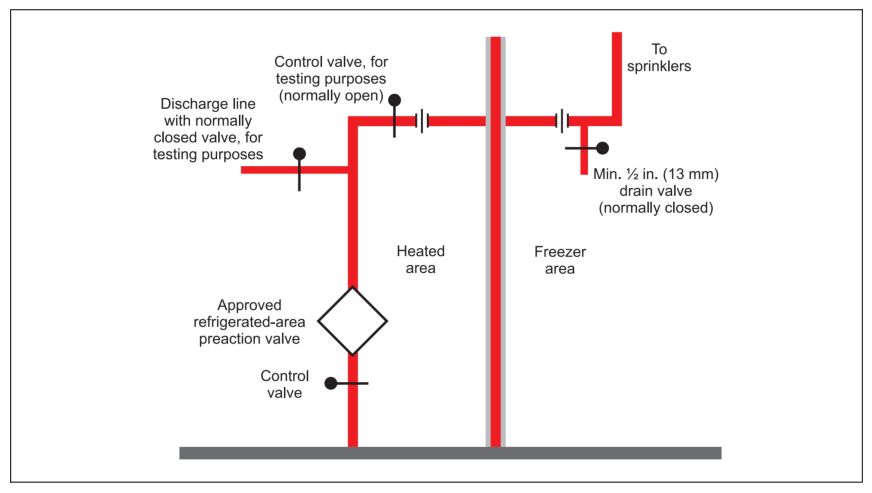

In [65]:
# An example of some text that references a "Figure".
#
documnet_text = "See Figure 2.2.5.3.1 for an example of the riser piping arrangement of" 
documnet_text = documnet_text+ "a refrigerated-area sprinkler system."
#
if documnet_text.find("See Figure") != -1:
    #
    # Construct the file name to get
    #
    # get the substring after the word "Figure" and before the word "for"
    # so in this example: fig_str="
    fig_str=documnet_text.split("Figure")[1].split("for")[0].strip()
    # if the text was See Figure prfix the file name with "F"
    fig_prefix="F"
    file_name = "./" + directory_name + "/" + fig_prefix + "_" + fig_str + ".png"
    print(file_name)
    #show the image
    show_image(file_name)